### TF2.0 신경망 만들기
* CNN 신경망 이해
* 고양이와 개의 분류를 CNN을 이용하여 구현해 보기

In [ ]:
# 기타 설치시
# !pip install -q tensorflow-gpu==2.0.0-rc1

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)

1.15.0


### 데이터 불러오기
* Kaggle의 필터링 된 버전의 Dogs vs Cats 데이터 세트를 사용

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
print(PATH)

68608000/68606236 [==============================] - 82s 1us/step
C:\Users\peop\.keras\datasets\cats_and_dogs_filtered


```
cats_and_dogs_filtered
|__ train
    |______ cats: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ dogs: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ validation
    |______ cats: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
```

In [5]:
train_dir = os.path.join(PATH, 'train')            # 학습용
validation_dir = os.path.join(PATH, 'validation')  # 평가용
print(train_dir)
print(validation_dir)

C:\Users\peop\.keras\datasets\cats_and_dogs_filtered\train
C:\Users\peop\.keras\datasets\cats_and_dogs_filtered\validation


In [6]:
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures

print("개 : ", train_dogs_dir)
print("고양이 : ", train_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures

print("개 : ", validation_dogs_dir)
print("고양이 : ", validation_cats_dir)

개 :  C:\Users\peop\.keras\datasets\cats_and_dogs_filtered\train\dogs
고양이 :  C:\Users\peop\.keras\datasets\cats_and_dogs_filtered\train\cats
개 :  C:\Users\peop\.keras\datasets\cats_and_dogs_filtered\validation\dogs
고양이 :  C:\Users\peop\.keras\datasets\cats_and_dogs_filtered\validation\cats


### 데이터 탐색

In [7]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [8]:
## 이미지 개수
print('Total training cat images:', num_cats_tr)  # 고양이
print('Total training dog images:', num_dogs_tr)  # 개
print("--")

print('Total validation cat images:', num_cats_val)  # 고양이
print('Total validation dog images:', num_dogs_val)  # 개
print("--")

print("Total training images:", total_train)  #  학습용 = 개 + 고양이
print("Total validation images:", total_val)  #  평가용 = 개 + 고양이

Total training cat images: 1000
Total training dog images: 1000
--
Total validation cat images: 500
Total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [9]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

### 데이터 준비
* tf.keras에서 제공하는 ImageDataGenerator class
* 디스크에서 이미지를 읽고, 적절한 텐서로 사전 처리가 가능하다.

In [10]:
train_image_generator = ImageDataGenerator(rescale=1./255)      # 학습용 데이터 생성기
validation_image_generator = ImageDataGenerator(rescale=1./255) # 평가용 데이터 생성기

* 이미지 생성기를 정의한 후, flow_from_directory 메서드를 이용
  * 이미지를 로드
  * 이미지의 크기 조정 적용

In [11]:
print(train_dir) # 학습용
!ls /root/.keras/datasets/cats_and_dogs_filtered/train

C:\Users\peop\.keras\datasets\cats_and_dogs_filtered\train


'ls'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


* directory : 디렉터리는 class를 포함하고 있어야 한다.
* target_size : 입력 이미지의 사이즈 지정
* class_mode : 2개의 이미지라면 binary, 그 이상의 이미지 categorical

In [12]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary', 
                                                           seed=42)

Found 2000 images belonging to 2 classes.


In [13]:
print(validation_dir) # 학습용
!ls /root/.keras/datasets/cats_and_dogs_filtered/validation

C:\Users\peop\.keras\datasets\cats_and_dogs_filtered\validation


'ls'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [14]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                   directory=validation_dir,
                                                   target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                   class_mode='binary', 
                                                   seed=42)

Found 1000 images belonging to 2 classes.


### 이미지 추출 후, 이에 대한 시각화

In [15]:
sample_training_images, _ = next(train_data_gen)
sample_training_images.shape  # 이미지 추출

(128, 150, 150, 3)

In [16]:
# 이 함수는 이미지를 plot를 하는 함수.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

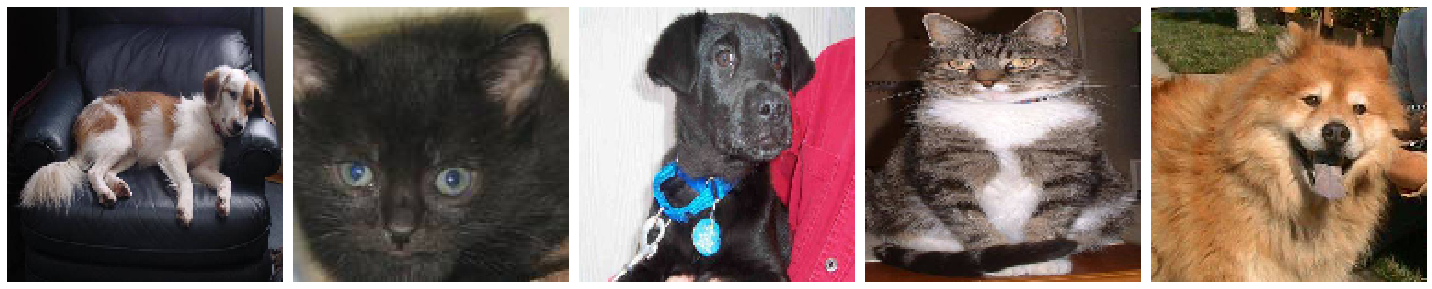

In [17]:
plotImages(sample_training_images[:5])

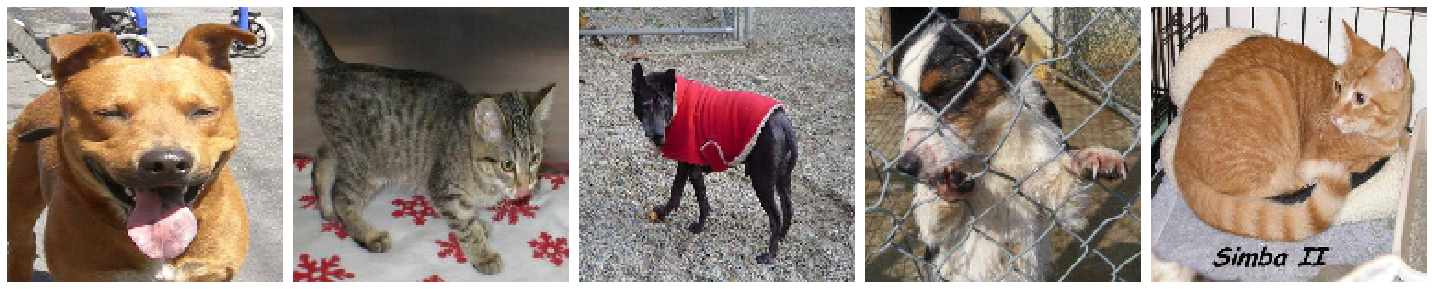

In [18]:
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

### 모델 만들기(Create the model)
* 개 고양이 분류(이진 분류) : 마지막 뉴런 1개(sigmoid)
* MNIST 분류 : 뉴런 10개(softmax)

In [19]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### 모델 컴파일(Compile the model)
* binary_crossentropy : label이 두개
* categorical_crossentropy : label이 여러개

In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

### 모델 훈련시키기
* model.fit() : 적은 데이터 셋
* model.fit_generator() : 중복 데이터를 피하려고 할때 사용. 킅 데이터 셋을 이용 할 때 사용.
  * 여기에서는 ImageDataGenerator의 fit_generator를 사용한다.

In [ ]:
%%time

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
15/15 [==============================] - 39s 3s/step - loss: 1.0086 - acc: 0.4941 - val_loss: 0.6978 - val_acc: 0.4933
Epoch 2/15
15/15 [==============================] - 36s 2s/step - loss: 0.6885 - acc: 0.5278 - val_loss: 0.6685 - val_acc: 0.6272
Epoch 3/15
15/15 [==============================] - 37s 2s/step - loss: 0.6529 - acc: 0.6276 - val_loss: 0.6299 - val_acc: 0.6228
Epoch 4/15
15/15 [==============================] - 35s 2s/step - loss: 0.6263 - acc: 0.6469 - val_loss: 0.6154 - val_acc: 0.6507
Epoch 5/15
15/15 [==============================] - 56s 4s/step - loss: 0.5775 - acc: 0.7115 - val_loss: 0.5951 - val_acc: 0.6741
Epoch 6/15
15/15 [==============================] - 60s 4s/step - loss: 0.5292 - acc: 0.7452 - val_loss: 0.5475 - val_acc: 0.7221
Epoch 7/15
15/15 [==============================] - 63s 4s/step - loss: 0.4684 - acc: 0.7823 - val_loss: 0.5521 - val_acc: 0.7243
Epoch 8/15
 4/15 [=======>......................] - ETA: 30s - loss: 0.4771 - acc: 0.7672

### 학습 모델 결과 시각화

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### REF
* 이미지 분류 : https://www.tensorflow.org/tutorials/images/classification
* ImageGenerator Class : https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
* Conv2D : https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D